# Inference of Gene Correlations using Pearson


In [46]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-08


In [71]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')

import lib.minibulk_funcs as mb
import lib.fun_plotting as fun_plotting
import lib.funcs_general as funcs_general
import lib.figs_funcs as figfunc


%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial information

In [48]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [49]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Raw data

In [50]:
df_raw = pd.read_csv(path_data + "GE_data/imp_genes_raw.csv", header=0, index_col=0, sep=",")
# time_sep = np.loadtxt(path+"GE_data/time_sep.txt", dtype=np.int32)
df_raw.index.name = None

df_raw = df_raw.reindex(genes_order)
    
df_raw.head(3)

,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1,1,0,1,3,3,0,2,2,0,...,0,2,1,0,0,0,0,0,0,0
Klf2,1,0,1,2,0,2,6,6,1,2,...,0,3,1,0,0,0,3,0,0,2
Esrrb,0,1,0,2,1,0,0,2,0,0,...,0,1,0,0,0,0,1,1,0,0


In [51]:
# PST
pst_df = pd.read_csv(path_data+'input_data/cellinfo_pseudotime_3no2CLC_22_09_22.txt',
                              header = 0, sep = ' ', quotechar = '"', 
                              names = ["barcodes", "time", "pst"])

pst_df = pst_df.sort_values(by=['pst'])

# riordino dataframe 
column_names = pst_df["barcodes"]
df_raw_pst = df_raw.reindex(columns = column_names)

df_raw_mb_pst = df_raw_pst.rolling(window = w_size, axis=1).mean().dropna(axis=1)
df_raw_mb_pst = pd.DataFrame(df_raw_mb_pst, index=df_raw_pst.index)
df_raw_mb_pst.head(3)



barcodes,GGCGTCAGTCAACGCC,CTCATGCGTCAGGTAG,CTGCCATAGACCGCCT,AGCCAATCAAATCAGA,CGGGTCATCTGGAGAG,TCATTTGTCATCGGGC,AGCATCAAGTACTGGG,ATTCAGGTCGGTTAGT,TCGATTTTCAATCCGA,TATCCTACATAGGTTC,...,TTTGACTTCGCCACTT,GCCATTCTCATTCACT,GAAACCTGTTGTGCCG,CAACCAAAGCCTCACG,TCCTCTTTCGTCCATC,CTAACCCCACAATGCT,CCACACTCACACCAGC,CACGTTCAGCCGAACA,TGATTCTTCCGTTTCG,CTTGATTCACCATTCC
Klf4,1.340000,1.340000,1.353333,1.353333,1.366667,1.406667,1.426667,1.426667,1.426667,1.413333,...,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.213333,0.213333
Klf2,1.233333,1.240000,1.226667,1.226667,1.233333,1.266667,1.260000,1.260000,1.280000,1.286667,...,0.633333,0.626667,0.606667,0.606667,0.580000,0.580000,0.573333,0.573333,0.560000,0.553333
Esrrb,0.240000,0.246667,0.253333,0.246667,0.233333,0.246667,0.260000,0.260000,0.260000,0.260000,...,0.206667,0.206667,0.206667,0.206667,0.206667,0.213333,0.213333,0.220000,0.226667,0.226667


# Norm Data

In [52]:
# load the Gene Expression data Log Normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None

df_lN.head(3)

# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## Pseudotime

In [53]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## MB

In [54]:
w_size = 150

In [55]:
df_raw_mb = mb.mov_avg(np.array(df_raw, dtype=int), wind=w_size)
df_raw_mb = pd.DataFrame(df_raw_mb, index=df_raw.index)
df_raw_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,1.793333,1.640000,1.533333,1.613333,1.426667,1.593333,1.533333,1.480000,1.826667,1.653333,...,0.406667,0.366667,0.326667,0.306667,0.260000,0.280000,0.353333,0.360000,0.286667,0.353333
Klf2,2.393333,2.153333,2.046667,2.173333,2.160000,1.940000,2.173333,2.153333,2.086667,2.260000,...,0.986667,0.886667,1.020000,0.766667,0.840000,0.773333,1.020000,0.873333,0.873333,0.906667
Esrrb,0.533333,0.573333,0.440000,0.513333,0.426667,0.380000,0.460000,0.560000,0.453333,0.513333,...,0.246667,0.293333,0.240000,0.220000,0.226667,0.206667,0.226667,0.173333,0.240000,0.233333


In [56]:
df_lN_mb = mb.mov_avg(np.array(df_lN, dtype=int), wind=w_size)
df_lN_mb = pd.DataFrame(df_lN_mb, index=df_lN.index)
df_lN_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,0.873333,0.793333,0.753333,0.86,0.760000,0.840000,0.733333,0.780000,0.880000,0.786667,...,0.200000,0.160000,0.133333,0.173333,0.126667,0.146667,0.200000,0.186667,0.113333,0.173333
Klf2,1.060000,0.973333,0.966667,1.04,1.033333,0.906667,0.993333,1.120000,0.966667,1.033333,...,0.466667,0.380000,0.506667,0.413333,0.393333,0.413333,0.513333,0.480000,0.400000,0.473333
Esrrb,0.226667,0.280000,0.220000,0.28,0.240000,0.226667,0.226667,0.293333,0.206667,0.273333,...,0.126667,0.153333,0.106667,0.120000,0.133333,0.093333,0.133333,0.120000,0.093333,0.120000


In [57]:
df_pN_mb = mb.mov_avg(np.array(df_pN, dtype=int), wind=w_size)
df_pN_mb = pd.DataFrame(df_pN_mb, index=df_pN.index)
df_pN_mb.head(3)

,0,1,2,3,4,5,6,7,8,9,...,9884,9885,9886,9887,9888,9889,9890,9891,9892,9893
Klf4,0.826667,0.760000,0.720000,0.813333,0.713333,0.793333,0.680000,0.746667,0.846667,0.773333,...,0.200000,0.146667,0.140000,0.160000,0.100000,0.146667,0.186667,0.173333,0.126667,0.180000
Klf2,1.066667,0.953333,0.980000,1.020000,1.060000,0.920000,0.980000,1.100000,0.946667,1.020000,...,0.453333,0.380000,0.493333,0.393333,0.366667,0.393333,0.486667,0.433333,0.406667,0.453333
Esrrb,0.220000,0.293333,0.206667,0.253333,0.233333,0.213333,0.213333,0.293333,0.213333,0.266667,...,0.120000,0.133333,0.100000,0.106667,0.120000,0.080000,0.126667,0.100000,0.093333,0.100000


## PST + MB

In [58]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [59]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape, "\nPsiNorm dims: ", df_pN_mb_pst.shape)

LogNorm dims:  (24, 9547) 
PsiNorm dims:  (24, 8124)


# Binarization (Half-max)

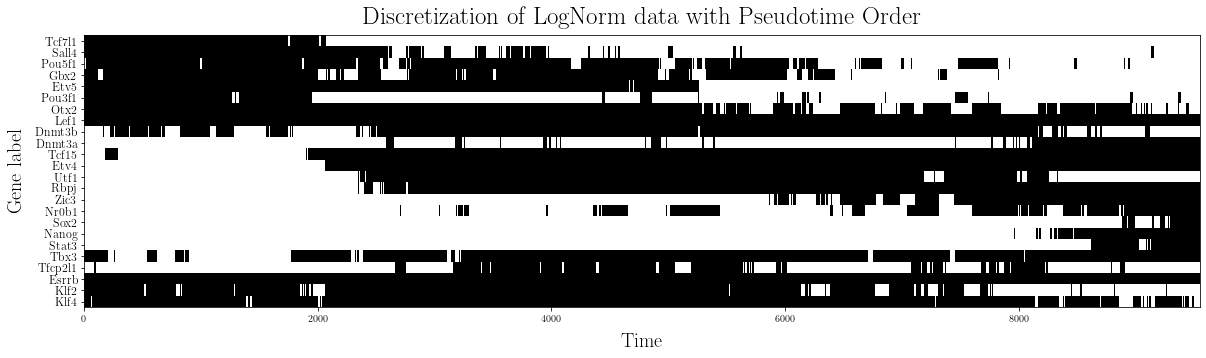

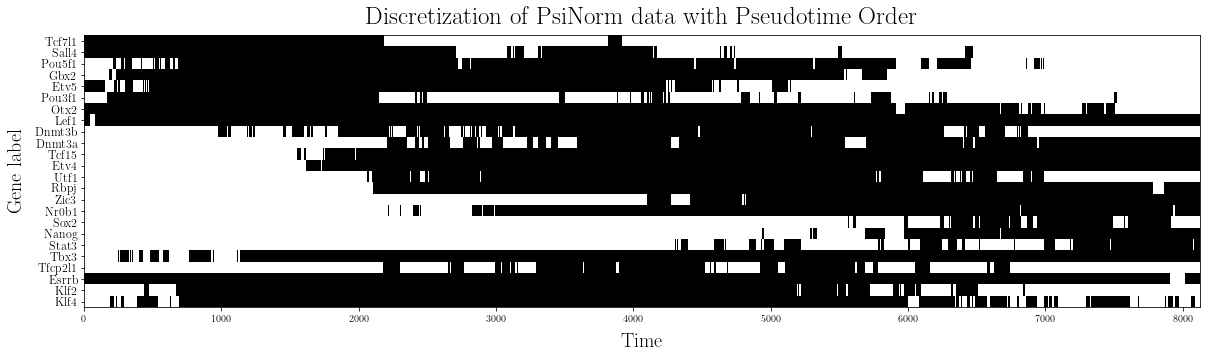

In [60]:
spins_df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()


spins_df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()



# Randomization

In [61]:
spins_df_lN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
spins_df_pN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 




In [62]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0


In [63]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            

# Known Experimentally

## Neighbours interactions

In [64]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [65]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

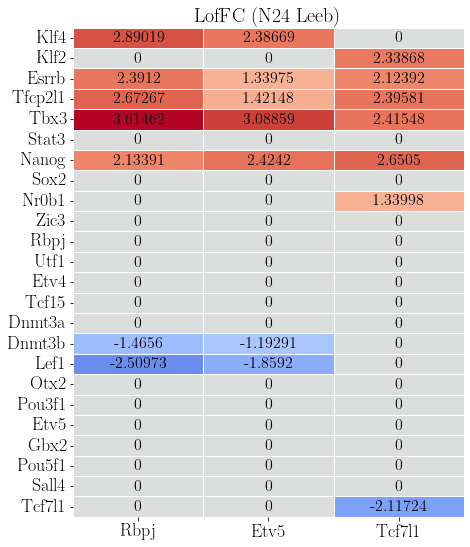

In [66]:
correlations_list = funcs_general.InteractionList(df_KO_N24_Leeb_cl, perc = 0.3)

fun_plotting.plot_log2FC(df_KO_N24_Leeb_cl, "LofFC (N24 Leeb)")

# Bulk Data

In [68]:
imp_genes = np.loadtxt(path_data+"general_info/imp_genes.csv", dtype="str")

file_name = path_data+"input_data/geni_IMP.xlsx"
df_bulk_all = pd.read_excel(file_name).set_index(imp_genes).reindex(genes_order)

df_bulk = df_bulk_all.iloc[:,2: ]
df_bulk.head(4)

# df2iL = df.iloc[:,2:18]
# df2i = df.iloc[:,18:]
# ntime=np.array([0, 0, 24, 24, 36, 36, 48, 48, 60, 60, 72, 72, 84, 84, 96, 96])



,GM_2iL_2,GM_2iL_1,GM_24h_2iL_2,GM_24h_2iL_1,GM_36h_2iL_2,GM_36h_2iL_1,GM_48h_2iL_2,GM_48h_2iL_1,GM_60h_2iL_2,GM_60h_2iL_1,...,GM_36h_2i_1,GM_36h_2i_2,GM_48h_2i_1,GM_48h_2i_2,GM_60h_2i_1,GM_60h_2i_2,GM_72h_2i_1,GM_72h_2i_2,GM_84h_2i_1,GM_84h_2i_2
Klf4,721.246075,790.448527,362.034812,507.580169,338.426474,275.595044,109.118435,141.201368,31.593545,46.465603,...,15.825195,7.814844,19.079327,14.208553,38.803582,25.553683,17.314668,14.76264,31.121266,16.477378
Klf2,300.890974,288.413501,124.602767,102.125740,87.270395,86.229124,51.552016,27.900029,31.593545,34.418965,...,25.056559,32.040862,42.928486,27.909658,39.896640,34.467758,16.527638,14.76264,13.103691,5.703708
Esrrb,179.939742,201.400614,103.999160,83.834562,47.694286,52.413781,24.916808,11.228061,6.651273,6.453556,...,3.956299,3.125938,4.769832,1.522345,2.186117,4.159902,3.148121,1.84533,1.637961,3.168726
Tfcp2l1,797.584148,796.803401,135.395133,111.271328,69.511885,70.166836,22.339207,18.713434,6.097000,6.453556,...,7.912597,5.470391,6.359776,6.089380,7.104881,7.725532,4.722182,9.22665,12.284710,8.238689


# Correlation Matrices

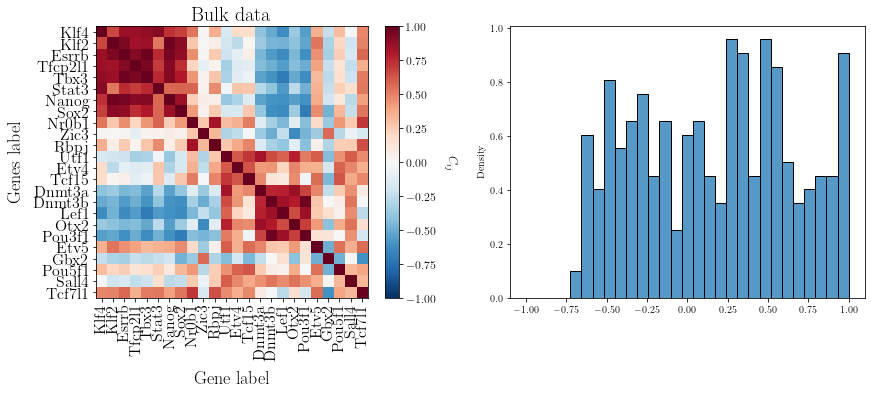

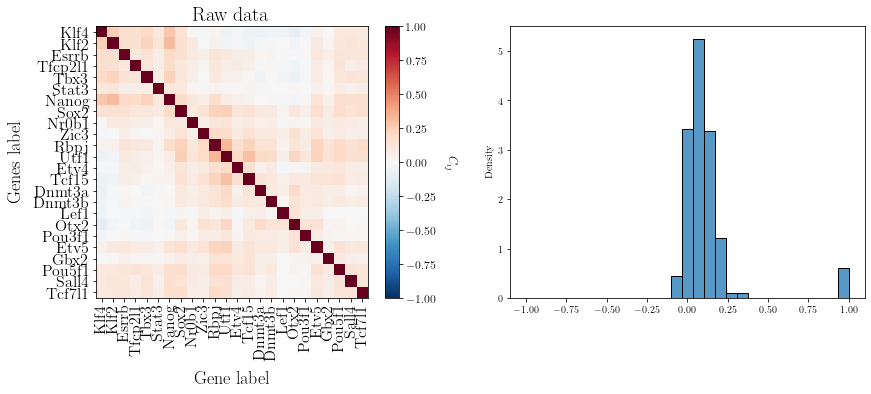

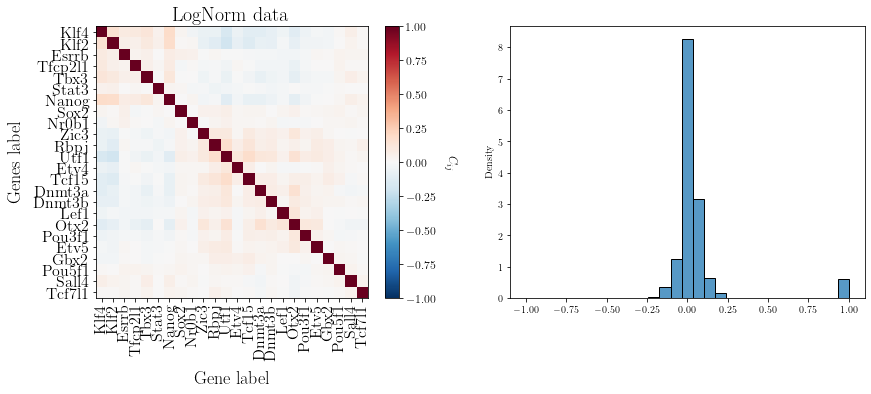

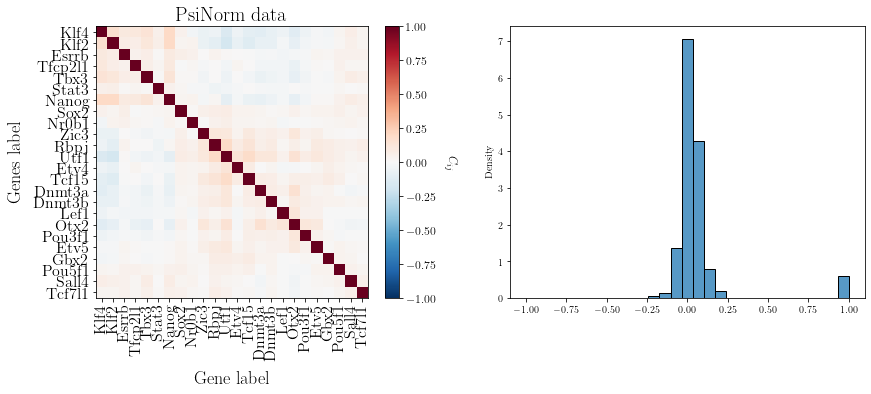

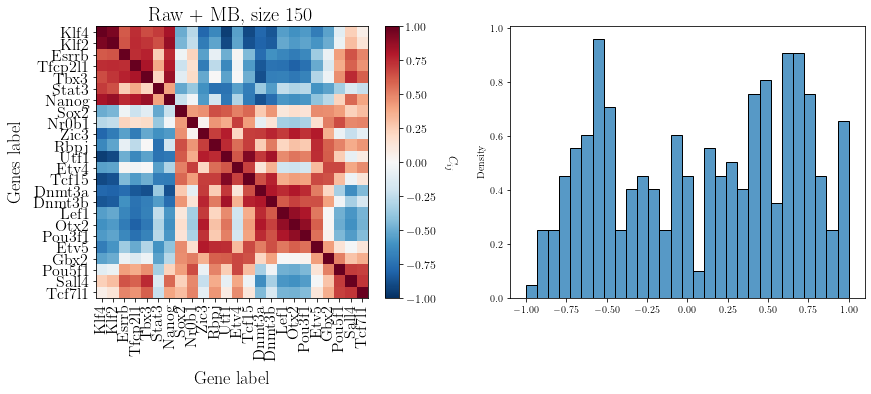

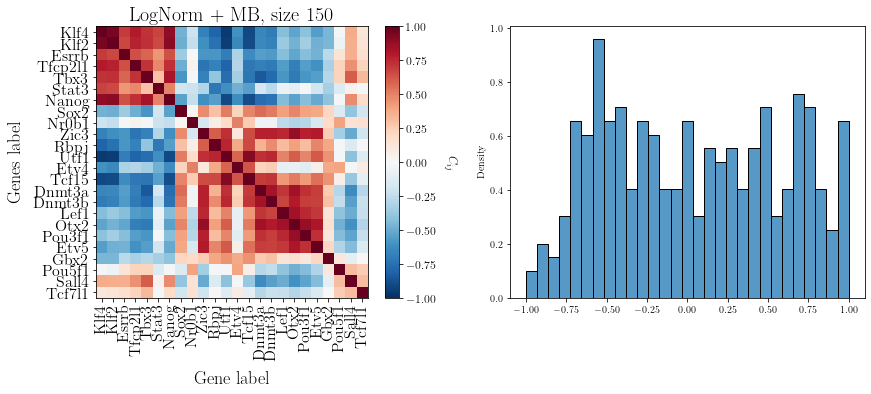

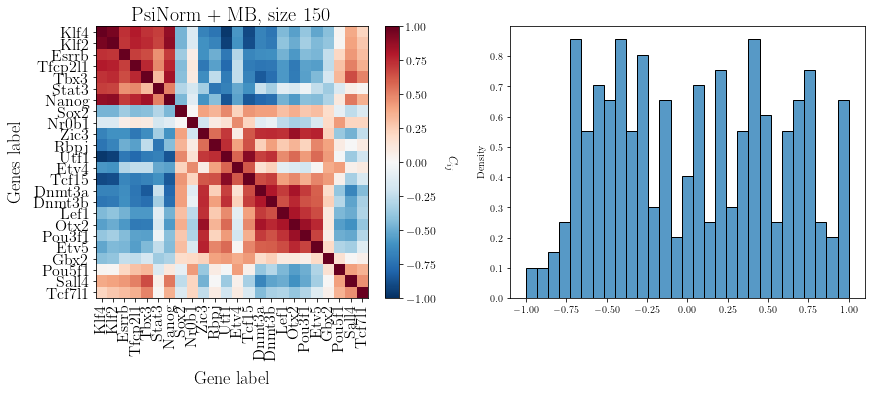

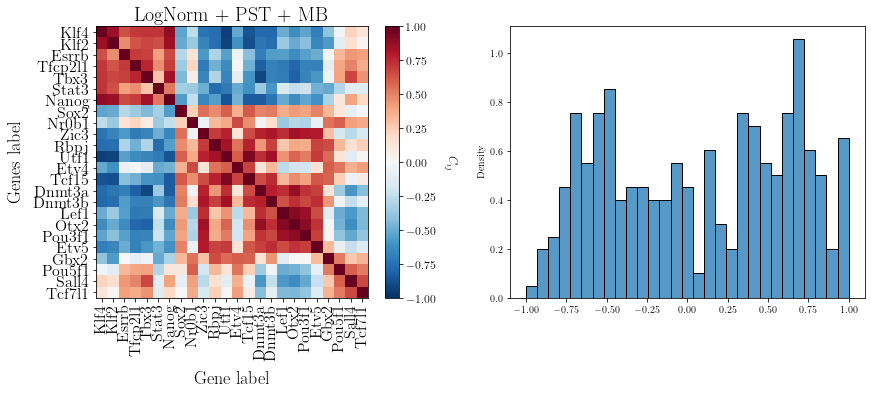

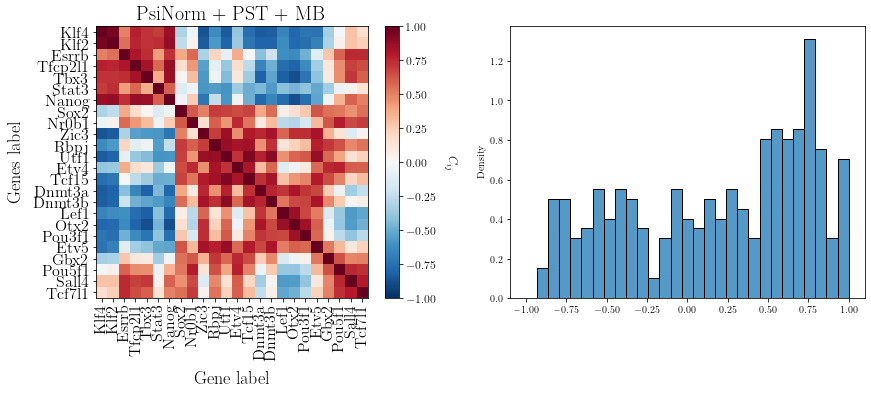

In [79]:
# optimize the code of the previous cell
bins = np.linspace(-1, 1, 30)

df_list = [df_bulk, df_raw, df_lN, df_pN, df_raw_mb, df_lN_mb, df_pN_mb, df_lN_mb_pst, df_pN_mb_pst]
df_name = ["Bulk data", "Raw data", "LogNorm data", "PsiNorm data", "Raw + MB, size "+str(w_size), "LogNorm + MB, size "+str(w_size), "PsiNorm + MB, size "+str(w_size), "LogNorm + PST + MB", "PsiNorm + PST + MB"]
for i in range(len(df_list)):
    cm = np.corrcoef(df_list[i])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    figfunc.plotmat(cm, fig, ax[0], df_raw.index, df_name[i], fix=True)
    sns.histplot(np.ndarray.flatten(cm), bins=bins, ax=ax[1], stat="density")
    plt.show()
    
    np.save(path_data + "OUT_Pearson/CM_" + df_name[i] + ".npy", cm)
    